## Tensorflow / Keras Tutorial ##

Tensorflow and Keras are Python libraries developed by Google for deep learning.

In [1]:
import tensorflow as tf
from tensorflow import keras

With Tensorflow you can build arbitrary "computation graphs" which specify the flow of computations from input to output.  The computation can happen on the CPU or GPU and can even be spread over multiple GPUs or distributed across multiple machines.

To use a GPU in Google Colab, be sure to select GPU under Runtime > Change Runtime Type > Hardware Accelerator.

In [2]:
a = tf.constant(5.)
b = tf.constant(5.)
(a + b).numpy()

np.float32(10.0)

You can define variables in Tensorflow, which can be initialized and later updated.  These could be used to represent weights in a neural network, for example.

In [ ]:
x = tf.Variable(initial_value=5,name='x')
y = x + 2
y

<tf.Tensor: shape=(), dtype=int32, numpy=7>

The real magic of Tensorflow is that it provides automatic differentiation.  You can ask it for the derivative of any tensor with respect to any variable and it will automatically compute it for you.

In Tensorflow 2, automatic differentation is enabled using GradientTape.

In [ ]:
x = tf.Variable(initial_value=5.,name='x')

with tf.GradientTape() as tape:
  y = 5*x + 2.
tape.gradient(y,x)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0>

We can use variables and automatic differentation to set up linear regression, for example.

In [ ]:
import numpy as np

w = tf.Variable(initial_value=np.random.randn(2,1),name='w')
b = tf.Variable(initial_value=np.zeros((1,1)),name='b')
x = [[1,2]]
y = [[3]]
# w1 * x1 + w2 * x2 + b = 3

with tf.GradientTape() as tape:
  z = x @ w + b
  loss = tf.reduce_mean((z-y)**2)
dLdw,dLdb = tape.gradient(loss,[w,b])
print('dL/dw:',dLdw)
print('dL/db:',dLdb)

dL/dw: tf.Tensor(
[[-2.71152596]
 [-5.42305191]], shape=(2, 1), dtype=float64)
dL/db: tf.Tensor([[-2.71152596]], shape=(1, 1), dtype=float64)


Tensorflow provides common neural network functions in the tf.nn package.

In [ ]:
x = tf.Variable(initial_value=-1.,name='x')
with tf.GradientTape() as tape:
  y = tf.nn.relu(x)
tape.gradient(y,x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

## Building a multi-layer perceptron in Tensorflow ##

Let's make a multi-layer perceptron in Tensorflow.  Thanks to autodiff, we don't need to worry about the Jacobians -- Tensorflow can figure it out for us!

First we will make a random, non-linearly separable dataset.

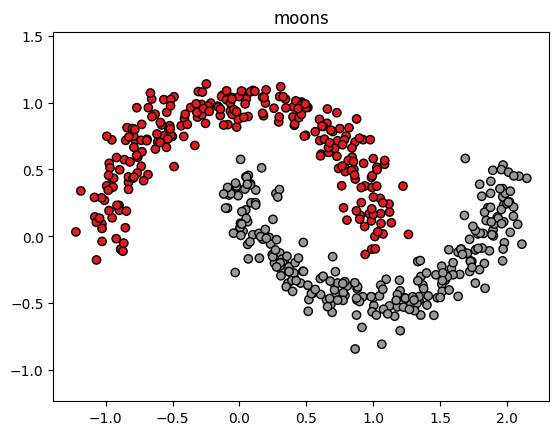

In [ ]:
from sklearn.datasets import make_moons
import numpy as np
from matplotlib import pyplot as plt

x,y = make_moons(n_samples=500,noise=0.1)
x = x.astype('float32')
y = y.astype('float32')
y = np.expand_dims(y,axis=-1)

plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.axis('equal')
plt.title('moons')
plt.show()

Now let's create variables for the weights and biases in the hidden and output layers.

In [ ]:
# hidden layer
w_h = tf.Variable(initial_value=np.random.randn(2,3)*0.01,dtype='float32',name='w_h')
b_h = tf.Variable(initial_value=np.zeros(3),dtype='float32',name='b_h')

# output layer
w_z = tf.Variable(initial_value=np.random.randn(3,1)*0.01,dtype='float32',name='w_z')
b_z = tf.Variable(initial_value=np.zeros(1),dtype='float32',name='b_z')

Now we will run gradient descent.  We will put our forward pass code inside GradientTape so that the gradients will be computed.  At the end of each iteration we use the gradients to update the weights and biases.

In [ ]:
num_iter = 2000
lr = 1.

vars = [w_h,b_h,w_z,b_z]
losses = []

for iter in range(num_iter):
  with tf.GradientTape() as tape:
    # hidden layer 1
    h = x @ w_h + b_h
    h = tf.nn.tanh(h)

    # output layer
    z = h @ w_z + b_z

    # binary cross-entropy loss
    loss = y * tf.nn.softplus(-z) + (1-y)*tf.nn.softplus(z)
    loss = tf.reduce_mean(loss)

  # get gradients
  grads = tape.gradient(loss,vars)

  # gradient descent
  for grad,var in zip(grads,vars):
    var.assign_add(-lr*grad)

  losses.append(loss.numpy())

  if iter % 50 == 0:
    print('step %d: loss: %0.2f'%(iter,loss))

step 0: loss: 0.69
step 50: loss: 0.27
step 100: loss: 0.26
step 150: loss: 0.26
step 200: loss: 0.26
step 250: loss: 0.26
step 300: loss: 0.26
step 350: loss: 0.26
step 400: loss: 0.26
step 450: loss: 0.26
step 500: loss: 0.26
step 550: loss: 0.26
step 600: loss: 0.26
step 650: loss: 0.26
step 700: loss: 0.26
step 750: loss: 0.26
step 800: loss: 0.25
step 850: loss: 0.25
step 900: loss: 0.25
step 950: loss: 0.25
step 1000: loss: 0.25
step 1050: loss: 0.25
step 1100: loss: 0.25
step 1150: loss: 0.25
step 1200: loss: 0.25
step 1250: loss: 0.25
step 1300: loss: 0.24
step 1350: loss: 0.24
step 1400: loss: 0.24
step 1450: loss: 0.24
step 1500: loss: 0.23
step 1550: loss: 0.23
step 1600: loss: 0.22
step 1650: loss: 0.14
step 1700: loss: 0.05
step 1750: loss: 0.03
step 1800: loss: 0.03
step 1850: loss: 0.02
step 1900: loss: 0.02
step 1950: loss: 0.02


Plot of loss over time:

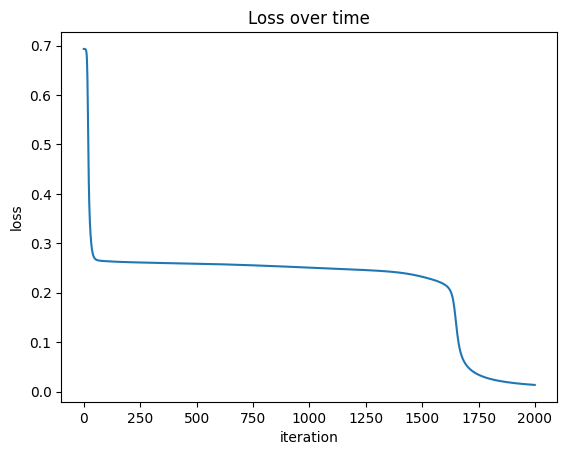

In [ ]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss over time')
plt.show()

Now we can run the trained neural network on the data and check the accuracy.

In [ ]:
# forward pass
h2 = x @ w_h + b_h
h2 = tf.nn.tanh(h)
z = h2 @ w_z + b_z

# compute accuracy
pred = (z>0).numpy().astype('int32')
acc = np.count_nonzero(pred==y)/len(y)
print('Accuracy: %.2f%%'%(acc*100))

Accuracy: 100.00%


## Neural Networks in Keras ##

Keras makes it much easier to set up a neural network.  It is an object-oriented framework that provides classes for many common neural network layers, activations, losses, optimizers, and metrics, as well as many other convenient features.

The entire network is encapsulated in a Model class which can be trained using .fit().

In [ ]:
from tensorflow.keras import layers
model = tf.keras.Sequential(
    [layers.Input((2,)),
     layers.Dense(3,activation='tanh',name='h'),
     layers.Dense(1,activation='sigmoid',name='z')
    ]
)
opt = tf.keras.optimizers.SGD(learning_rate=lr,momentum=0.)
model.compile(loss='binary_crossentropy',optimizer=opt)

history = model.fit(x,y,batch_size=len(x),epochs=2000,verbose=False)

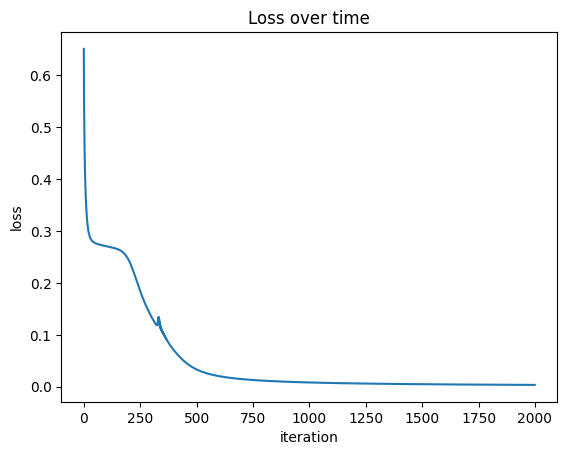

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss over time')
plt.show()

In [ ]:
pred = (model.predict(x)>0.5).astype('int32')
acc = np.count_nonzero(pred==y)/len(y)
print('Accuracy: %.2f%%'%(acc*100))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy: 100.00%


### Custom training loop

Sometimes you need to write a custom training loop with a Keras model.  This can be done using GradientTape.

Note that we don't need to compile the model in this case.

First we make some dummy data for a least squares regression problem.

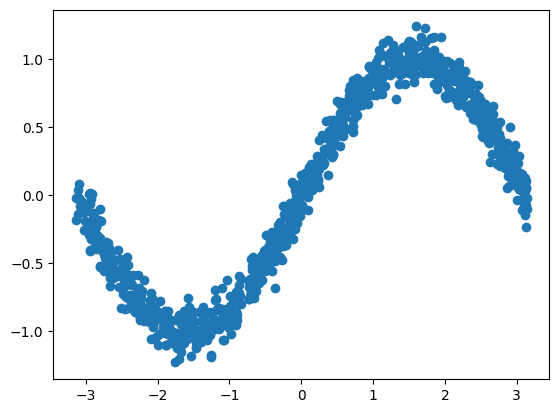

In [ ]:
x = np.random.uniform(-np.pi,np.pi,size=(1000,1))
y = np.sin(x)+np.random.normal(scale=0.1,size=x.shape)

plt.scatter(x,y)
plt.show()

In [ ]:
from tensorflow.keras import layers
model = tf.keras.Sequential(
    [
     layers.InputLayer((1,)),
     layers.Dense(3,activation='tanh',name='h'),
     layers.Dense(1,activation=None,name='z')
    ]
)

# create optimizer
opt = tf.keras.optimizers.Adam(.01)

loss_history = []
for i in range(2000):
  # turn on gradient tape to track loss computations
  # so that we can calculate gradient of the loss later
  with tf.GradientTape() as tape:
    # get predictions from model
    y_pred = model(x)
    # calculate mean squared error
    L = tf.reduce_mean((y-y_pred)**2)

  # get gradients of loss w.r.t. model parameters
  grads = tape.gradient(L,model.trainable_variables)

  # update model parameters using optimizer
  opt.apply_gradients(zip(grads,model.trainable_variables))

  # append loss to history so we can plot it later
  loss_history.append(L.numpy())


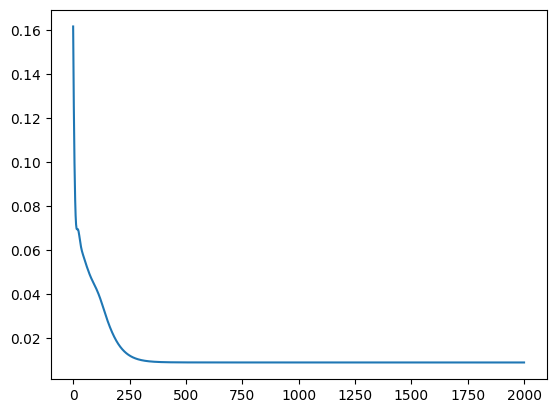

In [ ]:
plt.plot(loss_history)
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


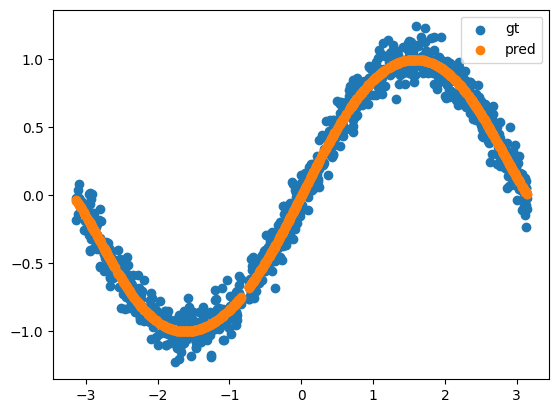

In [ ]:
pred = model.predict(x)
plt.scatter(x,y)
plt.scatter(x,pred)
plt.legend(['gt','pred'])
plt.show()

## Convolutional Neural Networks in Keras ##

Keras provides convolutional layers as well.  In Tensorflow and Keras, when using convolutional layers, the data has shape (B,H,W,C) where B is the batch size, H is the image height, W is the image width, and C is the number of channels.

First let's load the small UC Merced dataset from Tensorflow Datasets.  Description from the website:

"UC Merced is a 21 class land use remote sensing image dataset, with 100 images per class. The images were manually extracted from large images from the USGS National Map Urban Area Imagery collection for various urban areas around the country. The pixel resolution of this public domain imagery is 0.3 m.

While most images are 256x256 pixels, there are 44 images with different shape."

We will resize all the images to 32x32 to make the CNN training faster.


In [ ]:
import tensorflow_datasets as tfds
ds_train, ds_info = tfds.load('uc_merced', split='train', shuffle_files=True, with_info=True)

In [ ]:
x = []
y = []
for ex in ds_train:
  im = tf.image.resize(ex['image'],(32,32),method='area')
  im = im/255.
  label = ex['label']
  x.append(im)
  y.append(label)
x = tf.stack(x)
y = tf.stack(y)
print('x shape:',x.shape)
print('y shape:',y.shape)

x shape: (2100, 32, 32, 3)
y shape: (2100,)


Here are some example images with their labels.

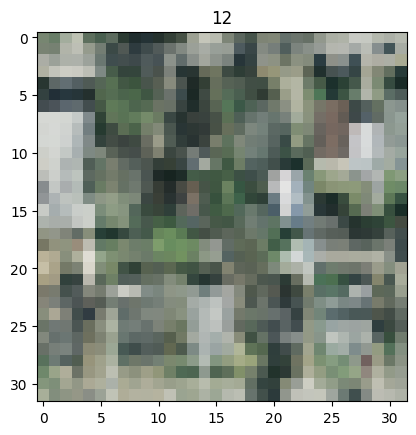

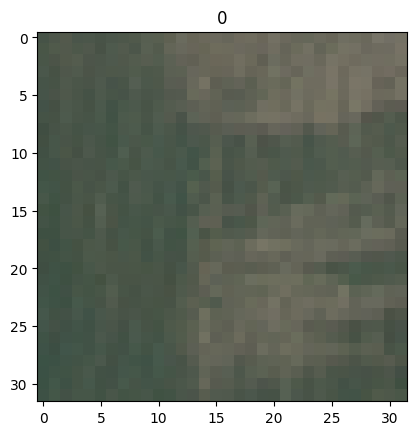

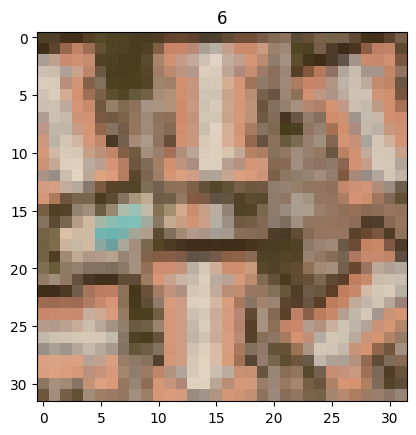

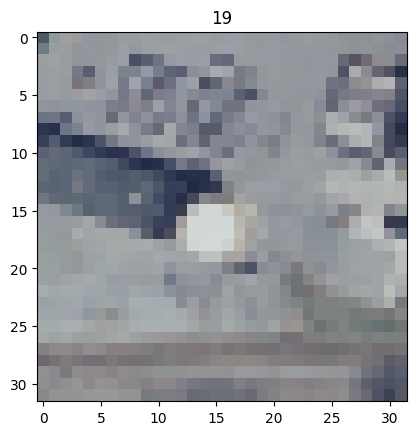

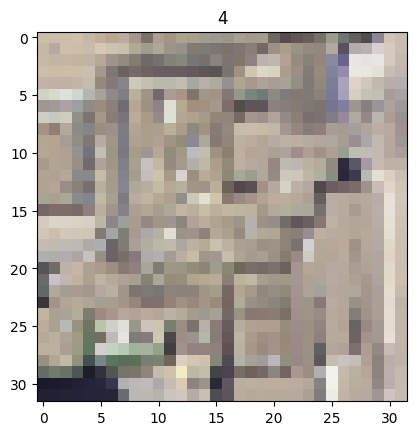

In [ ]:
for i in range(5):
  plt.imshow(x[i].numpy())
  plt.title(y[i].numpy())
  plt.show()

Now let's build a little VGG-style network.

We will use the Adam optimizer which is typically much better than vanilla SGD.

We will use the validation_split feature of Keras to automatically withold a validation set during training.

In [ ]:
from tensorflow.keras import layers

lr = 3e-4
batch_size = 32
epochs = 200

model = tf.keras.Sequential(
    [
     layers.Conv2D(32,3,activation='relu',padding='same',name='conv1a'),
     layers.Conv2D(32,3,activation='relu',padding='same',name='conv1b'),
     layers.MaxPooling2D(2,2),
     layers.Conv2D(64,3,activation='relu',padding='same',name='conv2a'),
     layers.Conv2D(64,3,activation='relu',padding='same',name='conv2b'),
     layers.MaxPooling2D(2,2),
     layers.Conv2D(128,3,activation='relu',padding='same',name='conv3a'),
     layers.Conv2D(128,3,activation='relu',padding='same',name='conv3b'),
     layers.MaxPooling2D(2,2),
     layers.Flatten(),
     layers.Dense(1024,activation='relu',name='dense1'),
     layers.Dense(21,activation='softmax',name='z')
    ]
)
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

history = model.fit(x,y,batch_size=batch_size,epochs=epochs,validation_split=0.1,verbose=True)

print(model.summary())

Epoch 1/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.0478 - loss: 3.0341 - val_accuracy: 0.1333 - val_loss: 2.8115
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1445 - loss: 2.6930 - val_accuracy: 0.2143 - val_loss: 2.3073
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2438 - loss: 2.2828 - val_accuracy: 0.2381 - val_loss: 2.4129
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3202 - loss: 2.0438 - val_accuracy: 0.4048 - val_loss: 1.8862
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4105 - loss: 1.8197 - val_accuracy: 0.4952 - val_loss: 1.5841
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4961 - loss: 1.6197 - val_accuracy: 0.4381 - val_loss: 1.7112
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4755 - loss: 1.5500 - val_accuracy: 0.5714 - val_loss: 1.3809
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6106 - loss: 1.2273 - val_accuracy: 0.5714 -

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1a (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1b (Conv2D)                 │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2a (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2b (Conv2D)                 │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3a (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3b (Conv2D)                 │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z (Dense)                       │ (None, 21)             │        21,525 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,220,129 (27.54 MB)

 Trainable params: 2,406,709 (9.18 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,813,420 (18.36 MB)

None


Plotting the training and validation loss and accuracy, we see that we are severely overfitting.  We could play with regularization and data augmentation to try to reduce the overfitting.

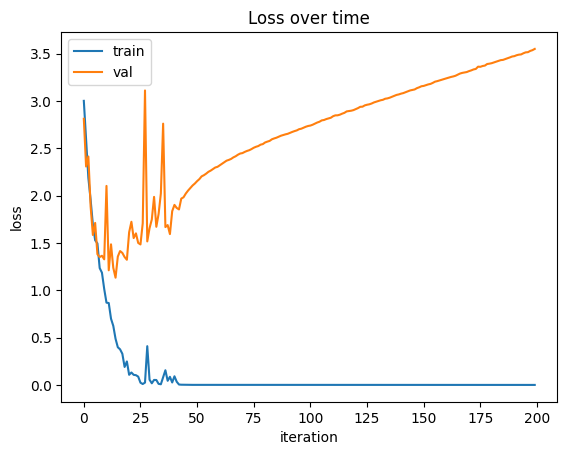

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss over time')
plt.legend(['train','val'])
plt.show()

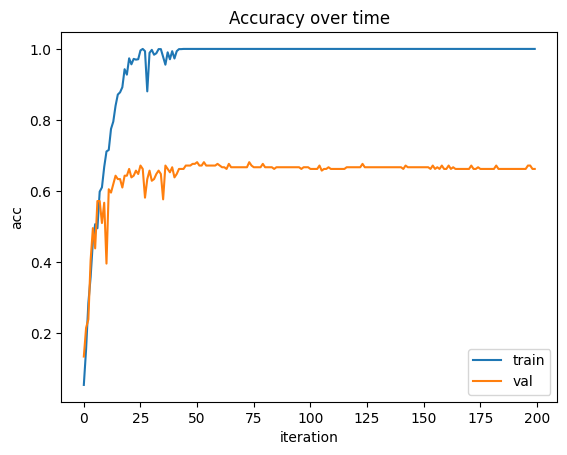

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('iteration')
plt.ylabel('acc')
plt.title('Accuracy over time')
plt.legend(['train','val'])
plt.show()